In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
global_learning_rate = 0.1
global_decay_rate = 0.5
global_decay_steps = 1000
num_iterations = 10000
num_logs = 10
num_repeats = 10
debug = False

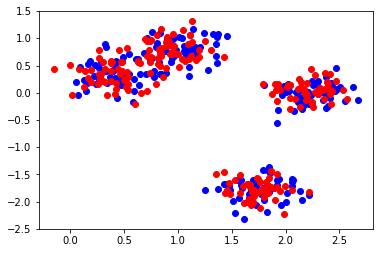

In [3]:
def set_seed():
    tf.set_random_seed(0)
    np.random.seed(0)
    
set_seed()

num_dims  =  2
num_centroids = 4
num_samples = 200

assert num_samples % num_centroids == 0

data_points = []
test_points = []

for i in range(num_dims):
    centroids = np.random.normal(0, 1, [num_centroids, 1])
    
    samples = centroids + np.random.normal(
        0, 0.2, [num_centroids, num_samples // num_centroids])
    tests = centroids + np.random.normal(
        0, 0.2, [num_centroids, num_samples // num_centroids])
    
    data_points.append(samples.flatten())
    test_points.append(tests.flatten())
    
data_points = np.stack(data_points).T
test_points = np.stack(test_points).T

data_labels = np.reshape(
    np.tile(
        np.eye(num_centroids)[:, np.newaxis, :], 
        [1, num_samples // num_centroids, 1]), 
    [num_samples, num_centroids])
test_labels = data_labels

plt.plot(data_points[:, 0], data_points[:, 1], "bo")
plt.plot(test_points[:, 0], test_points[:, 1], "ro")
plt.show()

In [14]:
def create_graph(metric):
    
    assert metric in ["loss", "accuracy"]

    set_seed()
    g_loss = tf.Graph()
    s_loss = tf.Session(graph=g_loss)

    with g_loss.as_default():

        data_in = tf.placeholder(
            tf.float32, shape=[num_samples, num_dims], name="data_in")
        labels_in = tf.placeholder(
            tf.float32, shape=[num_samples, num_centroids], name="labels_in")

        weights = tf.get_variable(
            name="weights",
            shape=[num_dims, num_centroids],
            initializer=tf.contrib.layers.xavier_initializer())
        biases = tf.get_variable(
            name="biases",
            shape=[num_centroids],
            initializer=tf.zeros_initializer())

        # Class probabilities conditioned on input: [batch, classes]
        logits = tf.nn.xw_plus_b(data_in, weights, biases)
        probs = tf.nn.softmax(logits)
        indices = tf.argmax(probs, axis=1)

        # Additonal axis for sampling probs: [batch, samples, classes]
        one_hot = tf.one_hot(
            tf.tile(
                tf.expand_dims(
                    tf.range(num_centroids), 
                    axis=0), 
                [num_samples, 1]), 
            num_centroids)

        # Additonal axis for sampling probs: [batch, samples, classes]
        labels_expand = tf.tile(
            tf.expand_dims(
                labels_in, axis=1), 
            [1, num_centroids, 1])

        # Cross entropy losses for batch: [1]
        cross_entropy = tf.reduce_mean(
            tf.reduce_sum(
                probs * tf.nn.softmax_cross_entropy_with_logits_v2(
                    logits=one_hot,
                    labels=labels_expand), 
                axis=1),
            axis=0)

        # Ones if correct, zeros otherwise: [batch, samples]
        hamming = tf.minimum(
            1, tf.cast(tf.abs(
                (tf.argmax(labels_expand, axis=2) - 
                    tf.argmax(one_hot, axis=2))), 
                tf.int32))

        # Fraction of wrong marks: [1]
        error_fraction = tf.reduce_mean(
            tf.reduce_sum(
                probs * tf.cast(hamming, tf.float32), 
                axis=1), 
            axis=0)
        accuracy = 1 - error_fraction

        global_step = tf.Variable(
            0, name="global_step", trainable=False)
        learning_rate = tf.train.exponential_decay(
            global_learning_rate, global_step,
            global_decay_steps, global_decay_rate)
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate)

        gradients = optimizer.compute_gradients(
            # Adaptive reinforcemnt learning target
            (cross_entropy if metric == "loss" 
                else error_fraction),
            var_list=[weights, biases])
        updates = optimizer.apply_gradients(
            gradients, 
            global_step=global_step)

        global_op = tf.global_variables_initializer()
        local_op = tf.local_variables_initializer()

    g_loss.finalize()
    return (s_loss, 
        global_op,
        local_op,
        cross_entropy, 
        accuracy, 
        updates)

In [15]:
def create_experiment(metric):
    
    (s_loss, 
        global_op,
        local_op,
        cross_entropy, 
        accuracy, 
        updates) = create_graph(metric)

    losses = []
    accuracies = []

    for r in range(num_repeats):
        current_loss = []
        current_accuracy = []
        s_loss.run([global_op, local_op])

        set_seed()

        for i in range(num_iterations):

            results = s_loss.run(
                [cross_entropy, accuracy, updates],
                feed_dict={
                    "data_in:0": data_points,
                    "labels_in:0": data_labels})

            current_loss.append([results[0], i])
            current_accuracy.append([results[1], i])

            if i % max(1, num_iterations // num_logs) == 0 and debug:
                print(
                    "iteration: %d" % i,
                    "loss: %.2f" % results[0],
                    "accuracy: %.2f" % (100.0 * results[1]))

        losses.append(current_loss)
        accuracies.append(current_accuracy)

    losses = np.array(losses)
    accuracies = np.array(accuracies)

    mean_losses = np.mean(losses[:, :, 0], axis=0)
    std_losses = np.std(losses[:, :, 0], axis=0)
    ind_losses = losses[0, :, 1]

    mean_accuracies = np.mean(accuracies[:, :, 0], axis=0)
    std_accuracies = np.std(accuracies[:, :, 0], axis=0)
    ind_accuracies = accuracies[0, :, 1]
    
    red_color = (1.0, 0, 0, 1.0)
    green_color = (0, 1.0, 0, 1.0)
    blue_color = (0, 0, 1.0, 1.0)

    red_color_light = (1.0, 0, 0, 0.2)
    green_color_light = (0, 1.0, 0, 0.2)
    blue_color_light = (0, 0, 1.0, 0.2)
    
    color_light = (red_color_light if metric == "loss" 
                else blue_color_light)
    color_dark = (red_color if metric == "loss" 
                else blue_color)

    plt.fill_between(
        ind_losses, 
        mean_losses + std_losses,
        mean_losses - std_losses, 
        facecolor=color_light, 
        interpolate=True)
    plt.plot(ind_losses, mean_losses, color=color_dark)
    plt.title("Training Loss Metric: " + metric)
    plt.xlabel("Iteration")
    plt.ylabel("Cross Entropy")
    plt.grid(True)
    plt.show()

    plt.close()

    plt.fill_between(
        ind_accuracies, 
        mean_accuracies + std_accuracies,
        mean_accuracies - std_accuracies, 
        facecolor=color_light, 
        interpolate=True)
    plt.plot(ind_accuracies, mean_accuracies, color=color_dark)
    plt.title("Training Accuracies Metric: " + metric)
    plt.xlabel("Iteration")
    plt.ylabel("Fraction Correct")
    plt.grid(True)
    plt.show()
    
    return [[mean_losses, std_losses, ind_losses], 
        [mean_accuracies, std_accuracies, ind_accuracies]]

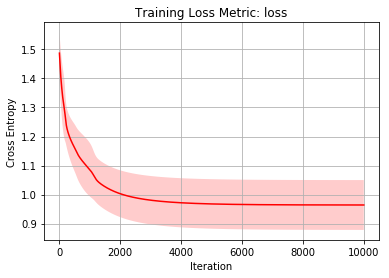

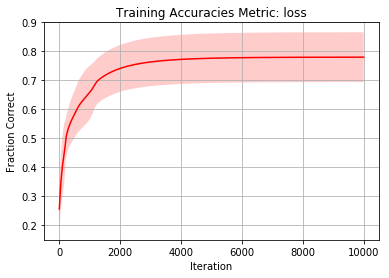

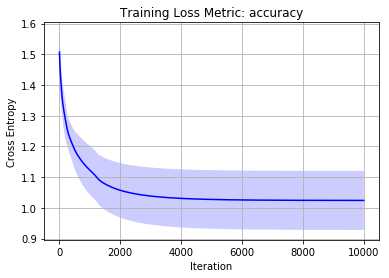

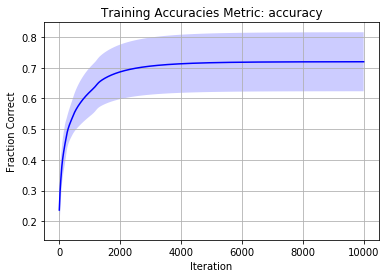

[[array([1.5072072 , 1.50443896, 1.50167445, ..., 1.02426347, 1.02426341,
         1.02426333]),
  array([0.06467628, 0.0654869 , 0.06627224, ..., 0.09607505, 0.09607509,
         0.09607509]),
  array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.997e+03, 9.998e+03,
         9.999e+03])],
 [array([0.2364612 , 0.23922938, 0.24199393, ..., 0.71940491, 0.71940499,
         0.71940504]),
  array([0.06467634, 0.06548696, 0.06627224, ..., 0.09607506, 0.09607506,
         0.09607509]),
  array([0.000e+00, 1.000e+00, 2.000e+00, ..., 9.997e+03, 9.998e+03,
         9.999e+03])]]

In [16]:
create_experiment("loss")
create_experiment("accuracy")